In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from collections import OrderedDict
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter 

Construction of model

In [2]:
class DropoutNetwork(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_num=2,proba_drop=0.5,tau=1.0):
        #assign module after called Module.__init__() 
        super(DropoutNetwork, self).__init__()
        
        #basic parameters
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.proba_drop=proba_drop
        self.hidden_dim=int((input_dim+output_dim)/2)

        
        #construction of input layers
        self.layer_in=nn.Linear(input_dim,self.hidden_dim)
        nn.init.normal_(self.layer_in.weight)
        
        #construction of hidden layers
        self.hidden_layer_list=[]
        for i in range(hidden_num):
            self.hidden_layer_list.append(('dense'+str(i+1),nn.Linear(self.hidden_dim,self.hidden_dim)))
            nn.init.normal_(self.hidden_layer_list[i*2][1].weight)
            self.hidden_layer_list.append(('relu'+str(i+1),nn.ReLU()))
        self.hidden_layer=nn.Sequential(OrderedDict(self.hidden_layer_list))
        #construction of output layers
        self.layer_out=nn.Linear(self.hidden_dim,self.output_dim)
        nn.init.normal_(self.layer_out.weight)
        
        
        
    def forward(self, xdata,drop_inplace=False):
        
        input=xdata.view(-1,self.input_dim)
        #Pass layer 1
        input=self.layer_in(input)
        #Remark: training = True may be change to self.training to compare pred MCdropout and pred naive.
        input=F.dropout(input,p=self.proba_drop,training=True,inplace=drop_inplace)
        input=F.relu(input)
        
        input=self.hidden_layer(input)
        #Pass layer 3 to get the output
        output=self.layer_out(input)
        
        return output

Parameters

In [3]:
batch_size=256
learning_rate=1e-3 #may be changed to adaptive rate
cuda=False
device = torch.device("cuda" if cuda else "cpu") 
input_dim=28*28
nclasses=10
hidden_layer_num=2
p_drop=0.5
n_epochs=40
pretrained=False

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

0it [00:00, ?it/s]

9920512it [00:06, 1535692.03it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 77588.02it/s]            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1382715.12it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 33309.43it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
model=DropoutNetwork(input_dim,nclasses,hidden_layer_num,p_drop)

In [11]:
if pretrained:
    model.load_state_dict(torch.load("./model_4couches_class.pt"))
    model.eval()

In [7]:
def test_drop(T=100,criterion = nn.CrossEntropyLoss(),printInfo=False):
    model.train()
    test_loss=0
    correct=0
    
    for batch_idx, (xdata,ydata) in enumerate(test_loader):
        batch_size=xdata.shape[0]
        xdata=xdata.to(device).view(batch_size,-1)
        ydata=ydata.to(device)
        outputlist=[]
        predlist=[]
        for i in range(T):
            output=model(xdata)
            #used for prediction
            pred=F.softmax(output,dim=1)
            pred=(pred==pred.max(dim=1,keepdim=True)[0]).float()
            
            predlist.append(torch.unsqueeze(pred,0))
            #used for loss calculation
            outputlist.append(torch.unsqueeze(output,0))
        #calculate loss
        output_cat=torch.cat(outputlist,dim=0)
        output_mean=output_cat.mean(dim=0)
        test_loss+=criterion(output_mean,ydata)
        #prediction
        pred_cat=torch.cat(predlist,dim=0)
        
        
        pred=pred_cat.mean(dim=0).squeeze().max(dim=1,keepdim=True)[1]
        
        #pred=output_mean.max(dim=1,keepdim=True)[1]
        correct+=pred.eq(ydata.view_as(pred)).cpu().sum()
        if printInfo and (batch_idx+1) % (int(len(test_loader)/10))==0:
            print("Test finished {:.0f}%".format(100. * (batch_idx+1) / len(test_loader)))
    test_loss/=len(test_loader)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
def train(n_epochs=50,display_step=10,criterion = nn.CrossEntropyLoss(),lr=learning_rate):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(),lr)
    for epoch in range(n_epochs):
        epoch_loss=0
        

        for batch_idx, (xdata,ydata) in enumerate(train_loader):
            #if we have cuda
            xdata=xdata.to(device)
            ydata=ydata.to(device)

            optimizer.zero_grad()
            output=model(xdata)
            loss=criterion(output,ydata)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()
            
            if batch_idx % display_step==0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)] lr: {}\tLoss: {:.6f}'
                  .format(epoch+1, batch_idx * len(ydata),
                          len(train_loader.dataset),
                          100. * batch_idx / len(train_loader),
                          lr/(epoch+1), loss.item()))
        print("Finish {} epoch(s). Epoch loss: {}.".format(epoch+1,epoch_loss/len(train_loader)))
        

In [12]:
def test_exam_faux(T=100,criterion = nn.CrossEntropyLoss()):
    model.train()
    test_loss=0
    correct=0
    
    test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True, **kwargs)
    
    for batch_idx, (xdata,ydata) in enumerate(test_loader):
        batch_size=xdata.shape[0]
        xdata_org=xdata
        xdata=xdata.to(device).view(batch_size,-1)
        ydata=ydata.to(device)
        #For each rotated image, calculate probabilitys
        outputlist=[]
        predlist=[]
        for i in range(10):
            for j in range(T):
                outputlist.append(F.softmax(model(xdata),dim=1).view(1,-1))
            output_cat=torch.cat(outputlist,dim=0)
            pred1=(output_cat==output_cat.max(dim=1,keepdim=True)[0]).float().mean(dim=0)
            predlist.append(pred1.unsqueeze(0))    

        output_mean=torch.cat(predlist,dim=0).mean(dim=0)

        output_std = torch.cat(predlist, dim=0).std(dim=0) #.mean().data[0]    
        outputlist=[]
        for i in range(T):
            outputlist.append(torch.unsqueeze(F.softmax(model(xdata),dim=1),0))
        output_mean=torch.cat(outputlist,dim=0).mean(dim=0)
        test_loss+=criterion(output_mean,ydata)
        pred=output_mean.max(dim=1,keepdim=True)[1]
        if pred.eq(ydata.view_as(pred)).cpu().sum()==1:
            correct+=1
        else:
            #print("Number is "+str(ydata.item())+", the picture is ")
            #plt.imshow(xdata_org.squeeze().detach().numpy())
            #pl
            fig=plt.figure()
            fig.add_subplot(2, 1, 1)
            plt.imshow(xdata_org.squeeze().detach().numpy())
            #plt.savefig('img_faux/bidx_{}_num_{}.png'.format(batch_idx,ydata.item()))
            output_std = torch.cat(outputlist, dim=0).std(dim=0).detach().squeeze().numpy() #.mean().data[0]
            output_mean=output_mean.detach().squeeze().numpy()
            x=np.linspace(0,9,10)
            fig.add_subplot(2, 1, 2)
            plt.plot(x,output_mean)
            plt.fill_between(x,output_mean-output_std,output_mean+output_std,alpha=0.1)
            plt.xlabel("class")
            plt.ylabel("mean")
            
            plt.savefig('img_faux/bidx_{}_num_{}_mean.png'.format(batch_idx,ydata.item()))
            
            plt.clf()
        if (batch_idx+1) % (int(len(test_loader)/10))==0:
            print("Test finished {:.0f}%".format(100. * (batch_idx+1) / len(test_loader)))
    test_loss/=len(test_loader)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
def test_uncertainty_rotation(T=100):
    model.train()
    #reset test data loader to get a random single image
    test_loader1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True, **kwargs)
    
    
    for batch_idx, (xdata,ydata) in enumerate(test_loader1):
        #Print number:
        print("Number is "+str(ydata.item()))
        plt.imshow(xdata.squeeze().detach().numpy())
        plt.show()
        #generate image rotation list
        image_list=[]
        rotation_list=np.linspace(0,360,10)
        #for plot
        plot_mean_list=[]
        plot_meanlow_list=[]
        plot_meanup_list=[]
        for i in range(10):
            plot_mean_list.append([])
            plot_meanup_list.append([])
            plot_meanlow_list.append([])
            
        for angle in rotation_list:
            rotation_matrix =torch.Tensor([[[math.cos(angle/360.0*2*math.pi), -math.sin(angle/360.0*2*math.pi), 0],
                                                    [math.sin(angle/360.0*2*math.pi), math.cos(angle/360.0*2*math.pi), 0]]])
            grid = F.affine_grid(rotation_matrix, xdata.size())
            xdata_rotate = F.grid_sample(xdata, grid)
            image_list.append(xdata_rotate.squeeze().detach().numpy())
            
            #For each rotated image, calculate probabilitys
            outputlist=[]
            
            for j in range(T):
                outputlist.append(F.softmax(model(xdata_rotate),dim=1).view(1,-1))
            output_cat=torch.cat(outputlist,dim=0)
            output_mean=(output_cat==output_cat.max(dim=1,keepdim=True)[0]).float().mean(dim=0)
            output_std=(output_cat==output_cat.max(dim=1,keepdim=True)[0]).float().std(dim=0)
            
            #calculate predicted class and  its confidence(probability)
            confidence = output_mean.cpu().detach().numpy().max()
            pred = output_mean.cpu().detach().numpy().argmax()
            
            #print info
            print ('rotation degree', str(angle).ljust(3), 'Uncertainty : {:.4f} Predict : {} Proba_max: {:.2f}'.format(output_std.mean(), pred, confidence))
            
            #For plot
            output_mean=output_mean.squeeze()
            output_std=output_std.squeeze()
            for i in range(10):
                plot_mean_list[i].append(output_mean[i].detach().numpy())
                #95% IC 
                plot_meanlow_list[i].append(output_mean[i].detach().numpy()-output_std[i].detach().numpy())
                plot_meanup_list[i].append(output_mean[i].detach().numpy()+output_std[i].detach().numpy())
            
            print("Finished angle:{}.".format(angle))
            
        #Plot
        print("Start plotting...")
        print("Rotation angles: "+str(rotation_list))
        colors=plt.cm.get_cmap('hsv',12)
        
        for i in range(10):
            #c=np.random.rand(3,1) ,color=c
            
            plt.plot(rotation_list,plot_mean_list[i],label="number "+str(i),color=colors(i))
            #print(plot_meanlow_list[i],",",plot_meanup_list[i])
            
            plt.fill_between(rotation_list,plot_meanlow_list[i],plot_meanup_list[i],color=colors(i),alpha=0.1)
        plt.ylim(0,1)
        plt.legend()    
        plt.show()
        
        #plot rotated images
        for i in range(10):
            plt.subplot(1,10,i+1)
            plt.imshow(image_list[i])
        
        plt.show()
        
        break
    

Number is 8


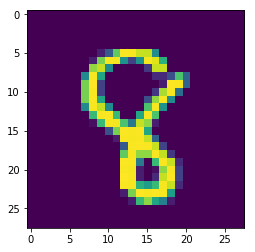

rotation degree 0.0 Uncertainty : 0.0000 Predict : 8 Proba_max: 1.00
Finished angle:0.0.
rotation degree 40.0 Uncertainty : 0.2099 Predict : 4 Proba_max: 0.35
Finished angle:40.0.
rotation degree 80.0 Uncertainty : 0.2063 Predict : 2 Proba_max: 0.37
Finished angle:80.0.
rotation degree 120.0 Uncertainty : 0.2303 Predict : 9 Proba_max: 0.32
Finished angle:120.0.
rotation degree 160.0 Uncertainty : 0.1068 Predict : 3 Proba_max: 0.71
Finished angle:160.0.
rotation degree 200.0 Uncertainty : 0.1224 Predict : 8 Proba_max: 0.66
Finished angle:200.0.
rotation degree 240.0 Uncertainty : 0.1258 Predict : 7 Proba_max: 0.71
Finished angle:240.0.
rotation degree 280.0 Uncertainty : 0.1430 Predict : 0 Proba_max: 0.67
Finished angle:280.0.
rotation degree 320.0 Uncertainty : 0.0000 Predict : 8 Proba_max: 1.00
Finished angle:320.0.
rotation degree 360.0 Uncertainty : 0.0000 Predict : 8 Proba_max: 1.00
Finished angle:360.0.
Start plotting...
Rotation angles: [  0.  40.  80. 120. 160. 200. 240. 280. 32

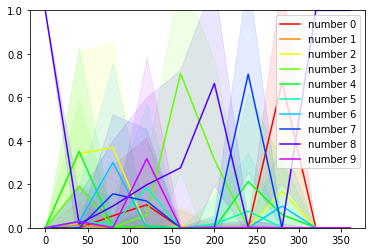

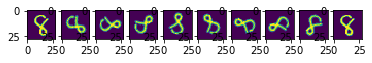

In [74]:
test_uncertainty_rotation(T=10000)

In [31]:
torch.save(model.state_dict(), "./model_4couches.pt")

In [57]:
def test_uncertainty_rotation_softmax(T=100):
    model.train()
    #reset test data loader to get a random single image
    test_loader1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True, **kwargs)
    
    
    for batch_idx, (xdata,ydata) in enumerate(test_loader1):
        #Print number:
        print("Number is "+str(ydata.item()))
        plt.imshow(xdata.squeeze().detach().numpy())
        plt.show()
        #generate image rotation list
        image_list=[]
        rotation_list=np.linspace(0,360,10)
        #for plot
        plot_mean_list=[]
        plot_meanlow_list=[]
        plot_meanup_list=[]
        for i in range(10):
            plot_mean_list.append([])
            plot_meanup_list.append([])
            plot_meanlow_list.append([])
            
        for angle in rotation_list:
            rotation_matrix =torch.Tensor([[[math.cos(angle/360.0*2*math.pi), -math.sin(angle/360.0*2*math.pi), 0],
                                                    [math.sin(angle/360.0*2*math.pi), math.cos(angle/360.0*2*math.pi), 0]]])
            grid = F.affine_grid(rotation_matrix, xdata.size())
            xdata_rotate = F.grid_sample(xdata, grid)
            image_list.append(xdata_rotate.squeeze().detach().numpy())
            
            #For each rotated image, calculate probabilitys
            outputlist=[]
            for i in range(T):
                outputlist.append(torch.unsqueeze(F.softmax(model(xdata_rotate),dim=1),0))
                
            output_mean=torch.cat(outputlist,dim=0).mean(dim=0)

            output_std = torch.cat(outputlist, dim=0).std(dim=0) #.mean().data[0]

            confidence = output_mean.cpu().detach().numpy().max()
            pred = output_mean.cpu().detach().numpy().argmax()

            print ('rotation degree', str(angle).ljust(3), 'Uncertainty : {:.4f} Predict : {} Softmax : {:.2f}'.format(output_std.mean(), pred, confidence))
            
            #For plot
            output_mean=output_mean.squeeze()
            output_std=output_std.squeeze()
            for i in range(10):
                plot_mean_list[i].append(output_mean[i].detach().numpy())
                plot_meanlow_list[i].append(output_mean[i].detach().numpy()-output_std[i].detach().numpy())
                plot_meanup_list[i].append(output_mean[i].detach().numpy()+output_std[i].detach().numpy())
            
            print("Finished angle:{}.".format(angle))
        print("Start plotting...")
        print("Rotation angles: "+str(rotation_list))
        colors=plt.cm.get_cmap('hsv', 10)
        for i in range(10):
            #c=np.random.rand(3,1) ,color=c
            plt.plot(rotation_list,plot_mean_list[i],label="number "+str(i),color=colors(i))
            #print(plot_meanlow_list[i],",",plot_meanup_list[i])
            plt.fill_between(rotation_list,plot_meanlow_list[i],plot_meanup_list[i],color=colors(i),alpha=0.1)
        plt.legend()    
        plt.show()
        
        #plot rotated images
        for i in range(10):
            plt.subplot(1,10,i+1)
            plt.imshow(image_list[i])
        
        plt.show()
        
        break

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f0688877468> returned a result with an error set

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

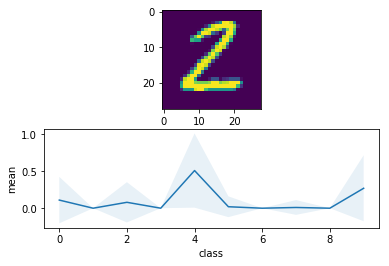

In [14]:
test_exam_faux()